In [7]:
import pickle
import cv2
import glob
import time
import numpy as np

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [11]:
# Load training data files
def load_training_set():
    trainning_vehicles = glob.glob('vehicles/*/*.png')
    training_non_vehicles = glob.glob('non-vehicles/*/*.png')
    print(len(trainning_vehicles), len(training_non_vehicles))
    return trainning_vehicles, training_non_vehicles

default_orient = 9
default_pix_per_cell = 8
default_cell_per_block = 2

# Define a function to return HOG features and visualization, copy from provided material
def get_hog_features(img, orient=default_orient, pix_per_cell=default_pix_per_cell, cell_per_block=default_cell_per_block, 
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features


8792 8968


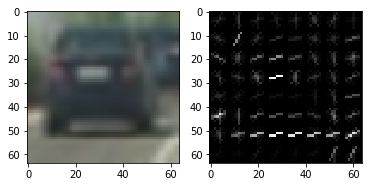

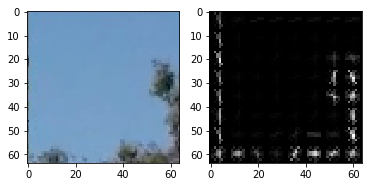

In [22]:
trainning_vehicles, training_non_vehicles = load_training_set()
v_image = mpimg.imread(trainning_vehicles[0])
n_v_image = mpimg.imread(training_non_vehicles[0])

vehicle_feature, vehicle_hog_image = get_hog_features(v_image[:,:,2], vis=True, feature_vec=True)
non_vehicle_feature, non_vehicle_hog_image = get_hog_features(n_v_image[:,:,2], vis=True, feature_vec=True)

#Plot vehicle and hog feature
fig = plt.figure()
plt.subplot(121)
plt.imshow(v_image, cmap='gray')
plt.subplot(122)
plt.imshow(vehicle_hog_image, cmap='gray')

#Plot non vehicle and hog feature
fig = plt.figure()
plt.subplot(121)
plt.imshow(n_v_image, cmap='gray')
plt.subplot(122)
plt.imshow(non_vehicle_hog_image, cmap='gray')


In [34]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append hog feature vector to features list
        vehicle_feature = get_hog_features(feature_image[:,:,2], vis=False, feature_vec=True)     
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, vehicle_feature)))
    # Return list of feature vectors
    return features

# build training vector set as well as labels
training_vehicles_features = extract_features(trainning_vehicles)
training_non_vehicles_features = extract_features(training_non_vehicles)
X_training = np.vstack((training_vehicles_features, training_non_vehicles_features)).astype(np.float64)  
y_label = np.hstack((np.ones(len(training_vehicles_features)), 
              np.zeros(len(training_non_vehicles_features))))